---
## 1. Import Libraries & Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import joblib
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load preprocessed data
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"✅ Data loaded successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")
print(f"\n📋 Features ({len(X_train.columns)}): {list(X_train.columns)}")

✅ Data loaded successfully!

📊 Dataset Shapes:
   X_train: (1069, 19)
   X_test: (268, 19)
   y_train: (1069,)
   y_test: (268,)

📋 Features (19): ['age', 'sex', 'bmi', 'children', 'smoker', 'age_bmi_interaction', 'smoker_bmi_interaction', 'is_smoker', 'is_obese', 'smoker_obese_risk', 'has_children', 'region_northwest', 'region_southeast', 'region_southwest', 'age_group_senior', 'age_group_young', 'bmi_category_obese', 'bmi_category_overweight', 'bmi_category_underweight']


---
## 2. Baseline Models

Starting with simple baseline models to establish performance benchmarks.

In [3]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a regression model.
    """
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                 scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results = {
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'CV Mean R²': cv_mean,
        'CV Std': cv_std,
        'Overfit Gap': train_r2 - test_r2
    }
    
    return results, model

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


---
## 3. Linear Models

Testing Linear Regression, Ridge, and Lasso.

In [4]:
# Initialize models
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42)
}

# Train and evaluate
linear_results = []
trained_linear_models = {}

print("\n🔄 Training Linear Models...\n")
print("=" * 90)

for name, model in linear_models.items():
    print(f"Training {name}...")
    results, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    linear_results.append(results)
    trained_linear_models[name] = trained_model
    
    print(f"  ✅ Test R²: {results['Test R²']:.4f} | RMSE: ${results['Test RMSE']:,.2f}")
    print()

# Display results
linear_df = pd.DataFrame(linear_results)
print("\n📊 Linear Models Performance:")
print("=" * 90)
print(linear_df.round(4))


🔄 Training Linear Models...

Training Linear Regression...
  ✅ Test R²: 0.9090 | RMSE: $4,089.33

Training Ridge Regression...
  ✅ Test R²: 0.9090 | RMSE: $4,088.59

Training Lasso Regression...
  ✅ Test R²: 0.9090 | RMSE: $4,088.69


📊 Linear Models Performance:
               Model  Train R²  Test R²  Test RMSE   Test MAE  CV Mean R²  \
0  Linear Regression    0.8569    0.909  4089.3328  2237.5484      0.8537   
1   Ridge Regression    0.8568    0.909  4088.5876  2235.5775      0.8537   
2   Lasso Regression    0.8569    0.909  4088.6908  2237.3412      0.8537   

   CV Std  Overfit Gap  
0  0.0226      -0.0521  
1  0.0226      -0.0522  
2  0.0226      -0.0522  


---
## 4. Ensemble Models

Testing Random Forest, Gradient Boosting, and XGBoost.

In [5]:
# Initialize ensemble models
ensemble_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, 
                                          random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                   learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                           random_state=42, n_jobs=-1)
}

# Train and evaluate
ensemble_results = []
trained_ensemble_models = {}

print("\n🔄 Training Ensemble Models...\n")
print("=" * 90)

for name, model in ensemble_models.items():
    print(f"Training {name}...")
    results, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    ensemble_results.append(results)
    trained_ensemble_models[name] = trained_model
    
    print(f"  ✅ Test R²: {results['Test R²']:.4f} | RMSE: ${results['Test RMSE']:,.2f}")
    print()

# Display results
ensemble_df = pd.DataFrame(ensemble_results)
print("\n📊 Ensemble Models Performance:")
print("=" * 90)
print(ensemble_df.round(4))


🔄 Training Ensemble Models...

Training Random Forest...
  ✅ Test R²: 0.8852 | RMSE: $4,592.57

Training Gradient Boosting...
  ✅ Test R²: 0.8892 | RMSE: $4,511.72

Training XGBoost...
  ✅ Test R²: 0.8890 | RMSE: $4,515.61


📊 Ensemble Models Performance:
               Model  Train R²  Test R²  Test RMSE   Test MAE  CV Mean R²  \
0      Random Forest    0.9525   0.8852  4592.5695  2593.6677      0.8285   
1  Gradient Boosting    0.9626   0.8892  4511.7177  2586.4017      0.8224   
2            XGBoost    0.9461   0.8890  4515.6140  2654.2705      0.8308   

   CV Std  Overfit Gap  
0  0.0171       0.0673  
1  0.0222       0.0733  
2  0.0195       0.0571  


In [6]:
# Test SVM
print("\n🔄 Training SVM...\n")
print("=" * 90)
print("⚠️ Note: SVR training may take a few minutes...")

svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_results, trained_svm = evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'Support Vector Machine')

print(f"✅ Test R²: {svm_results['Test R²']:.4f} | RMSE: ${svm_results['Test RMSE']:,.2f}")


🔄 Training SVM...

⚠️ Note: SVR training may take a few minutes...
✅ Test R²: -0.1278 | RMSE: $14,395.71


---
## 5. Model Comparison

Comparing all models side by side.

In [7]:
# Combine all results
all_results = linear_results + ensemble_results + [svm_results]
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("\n📊 ALL MODELS COMPARISON:")
print("=" * 110)
print(results_df.round(4).to_string())

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test R²']
best_rmse = results_df.iloc[0]['Test RMSE']

print("\n" + "=" * 110)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   Test RMSE: ${best_rmse:,.2f}")
print("=" * 110)


📊 ALL MODELS COMPARISON:
                    Model  Train R²  Test R²   Test RMSE   Test MAE  CV Mean R²  CV Std  Overfit Gap
0        Ridge Regression    0.8568   0.9090   4088.5876  2235.5775      0.8537  0.0226      -0.0522
1        Lasso Regression    0.8569   0.9090   4088.6908  2237.3412      0.8537  0.0226      -0.0522
2       Linear Regression    0.8569   0.9090   4089.3328  2237.5484      0.8537  0.0226      -0.0521
3       Gradient Boosting    0.9626   0.8892   4511.7177  2586.4017      0.8224  0.0222       0.0733
4                 XGBoost    0.9461   0.8890   4515.6140  2654.2705      0.8308  0.0195       0.0571
5           Random Forest    0.9525   0.8852   4592.5695  2593.6677      0.8285  0.0171       0.0673
6  Support Vector Machine   -0.0945  -0.1278  14395.7128  9249.1554     -0.0981  0.0246       0.0332

🏆 BEST MODEL: Ridge Regression
   Test R²: 0.9090 (90.90%)
   Test RMSE: $4,088.59


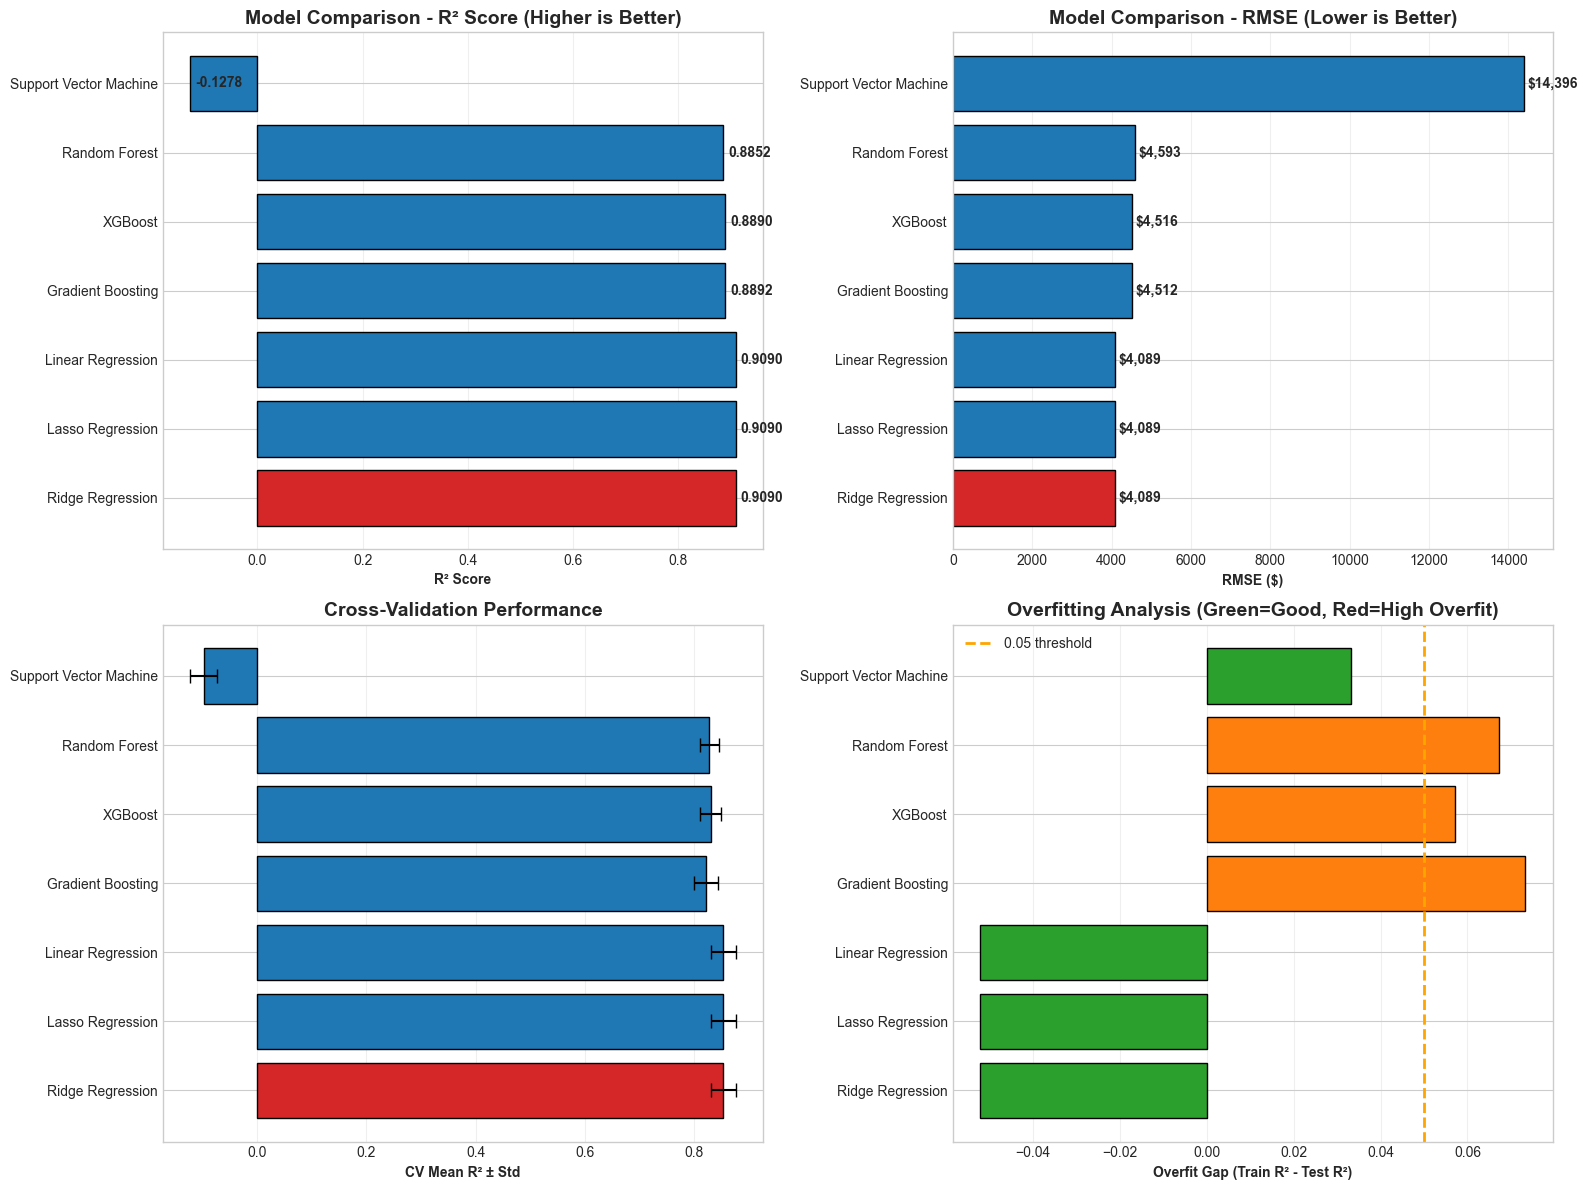


✅ Model comparison visualizations created!


In [8]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score comparison
ax = axes[0, 0]
colors = ['#1f77b4' if x != best_model_name else '#d62728' for x in results_df['Model']]
ax.barh(results_df['Model'], results_df['Test R²'], color=colors, edgecolor='black')
ax.set_xlabel('R² Score', fontweight='bold')
ax.set_title('Model Comparison - R² Score (Higher is Better)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(results_df['Test R²']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# RMSE comparison
ax = axes[0, 1]
ax.barh(results_df['Model'], results_df['Test RMSE'], color=colors, edgecolor='black')
ax.set_xlabel('RMSE ($)', fontweight='bold')
ax.set_title('Model Comparison - RMSE (Lower is Better)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(results_df['Test RMSE']):
    ax.text(v + 100, i, f'${v:,.0f}', va='center', fontweight='bold')

# Cross-validation scores
ax = axes[1, 0]
ax.barh(results_df['Model'], results_df['CV Mean R²'], 
        xerr=results_df['CV Std'], color=colors, edgecolor='black', capsize=5)
ax.set_xlabel('CV Mean R² ± Std', fontweight='bold')
ax.set_title('Cross-Validation Performance', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Overfitting analysis
ax = axes[1, 1]
overfit_colors = ['#2ca02c' if x < 0.05 else '#ff7f0e' if x < 0.1 else '#d62728' 
                  for x in results_df['Overfit Gap']]
ax.barh(results_df['Model'], results_df['Overfit Gap'], color=overfit_colors, edgecolor='black')
ax.set_xlabel('Overfit Gap (Train R² - Test R²)', fontweight='bold')
ax.set_title('Overfitting Analysis (Green=Good, Red=High Overfit)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='0.05 threshold')
ax.legend()

plt.tight_layout()
plt.show()

print("\n✅ Model comparison visualizations created!")

---
## 6. Hyperparameter Tuning

Fine-tuning the best performing model (Ridge Regression).

In [9]:
# Hyperparameter grid for Ridge
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Grid search with cross-validation
print("\n🔄 Performing Grid Search for Ridge Regression...\n")
print("=" * 70)

ridge_model = Ridge(random_state=42)
grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✅ Grid Search Complete!")
print("\n📊 Best Parameters:")
print(f"   Alpha: {grid_search.best_params_['alpha']}")
print(f"\n📊 Best Cross-Validation R² Score: {grid_search.best_score_:.4f}")

# Grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_alpha', 'mean_test_score', 'std_test_score']]
cv_results.columns = ['Alpha', 'Mean CV R²', 'Std CV R²']
cv_results = cv_results.sort_values('Mean CV R²', ascending=False)

print("\n📊 Grid Search Results:")
print(cv_results.to_string(index=False))


🔄 Performing Grid Search for Ridge Regression...

Fitting 5 folds for each of 6 candidates, totalling 30 fits

✅ Grid Search Complete!

📊 Best Parameters:
   Alpha: 1.0

📊 Best Cross-Validation R² Score: 0.8537

📊 Grid Search Results:
 Alpha  Mean CV R²  Std CV R²
   1.0    0.853683   0.022598
   0.1    0.853659   0.022579
  0.01    0.853654   0.022577
 0.001    0.853654   0.022576
  10.0    0.853330   0.022552
 100.0    0.849201   0.021795


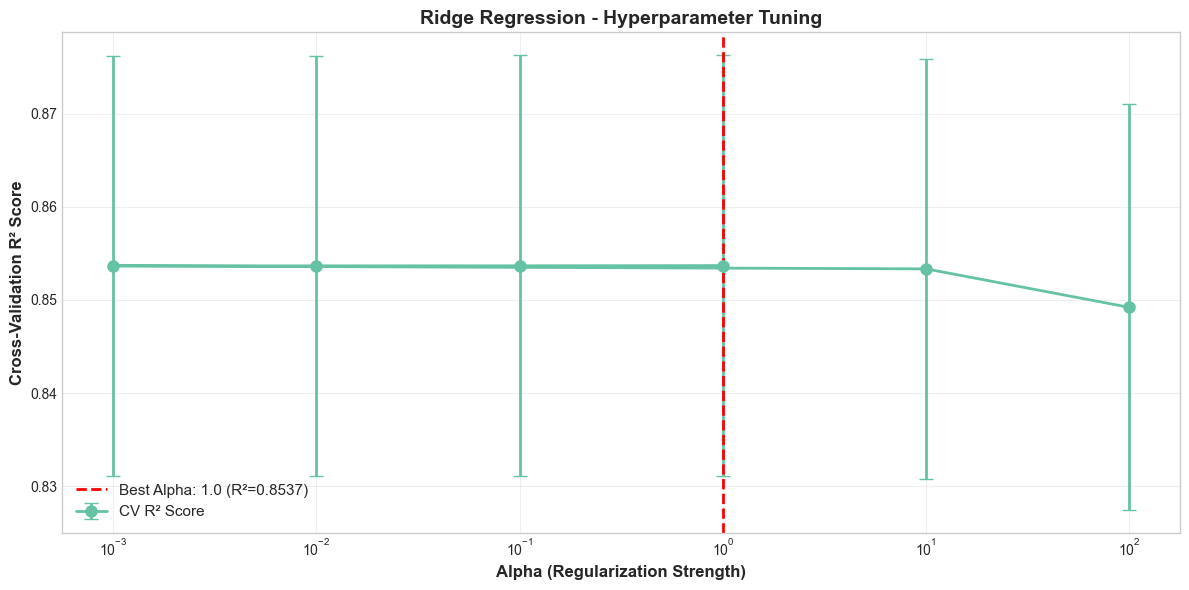


✅ Hyperparameter tuning visualization created!


In [10]:
# Visualize hyperparameter tuning
plt.figure(figsize=(12, 6))
plt.errorbar(cv_results['Alpha'], cv_results['Mean CV R²'], 
             yerr=cv_results['Std CV R²'], marker='o', capsize=5, 
             linewidth=2, markersize=8, label='CV R² Score')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)', fontweight='bold', fontsize=12)
plt.ylabel('Cross-Validation R² Score', fontweight='bold', fontsize=12)
plt.title('Ridge Regression - Hyperparameter Tuning', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Highlight best parameter
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_
plt.axvline(x=best_alpha, color='red', linestyle='--', linewidth=2, 
            label=f'Best Alpha: {best_alpha} (R²={best_score:.4f})')
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Hyperparameter tuning visualization created!")

---
## 7. Final Model Selection

Training the final model with optimized parameters.

In [11]:
# Train final model with best parameters
final_model = grid_search.best_estimator_

# Evaluate final model
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "=" * 70)
print("🏆 FINAL MODEL PERFORMANCE")
print("=" * 70)
print(f"\nModel: Ridge Regression (alpha={grid_search.best_params_['alpha']})")
print(f"\n📊 Training Metrics:")
print(f"   R² Score: {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"\n📊 Test Metrics:")
print(f"   R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"   RMSE: ${test_rmse:,.2f}")
print(f"   MAE: ${test_mae:,.2f}")
print(f"\n📊 Model Generalization:")
print(f"   Overfit Gap: {train_r2 - test_r2:.4f}")
print(f"   Status: {'✅ Good Generalization' if (train_r2 - test_r2) < 0.05 else '⚠️ Slight Overfitting'}")
print("\n" + "=" * 70)


🏆 FINAL MODEL PERFORMANCE

Model: Ridge Regression (alpha=1.0)

📊 Training Metrics:
   R² Score: 0.8568 (85.68%)

📊 Test Metrics:
   R² Score: 0.9090 (90.90%)
   RMSE: $4,088.59
   MAE: $2,235.58

📊 Model Generalization:
   Overfit Gap: -0.0522
   Status: ✅ Good Generalization



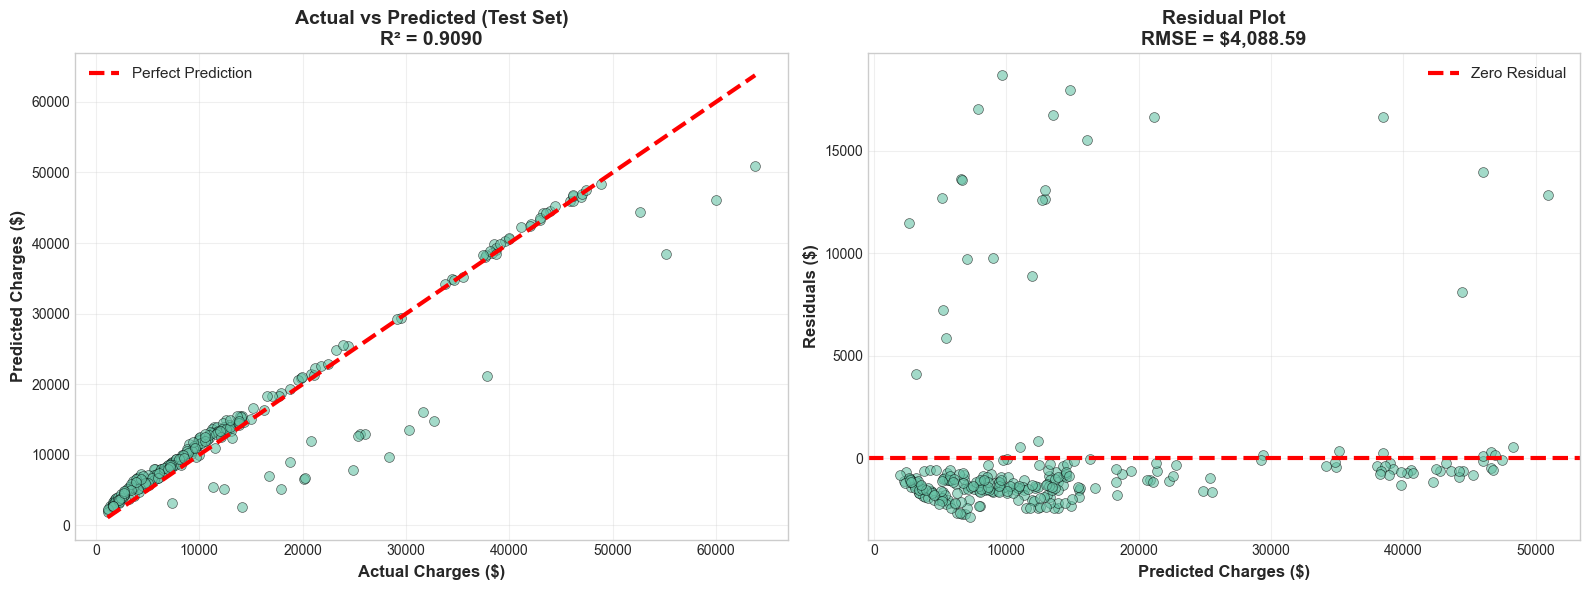


✅ Prediction visualizations created!


In [12]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted (Test Set)
ax = axes[0]
ax.scatter(y_test, y_test_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=3, label='Perfect Prediction')
ax.set_xlabel('Actual Charges ($)', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted Charges ($)', fontweight='bold', fontsize=12)
ax.set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}', 
             fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Residual plot
ax = axes[1]
residuals = y_test - y_test_pred
ax.scatter(y_test_pred, residuals, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.axhline(y=0, color='r', linestyle='--', linewidth=3, label='Zero Residual')
ax.set_xlabel('Predicted Charges ($)', fontweight='bold', fontsize=12)
ax.set_ylabel('Residuals ($)', fontweight='bold', fontsize=12)
ax.set_title(f'Residual Plot\nRMSE = ${test_rmse:,.2f}', 
             fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Prediction visualizations created!")

---
## 8. Save Best Model

Saving the trained model and metadata for deployment.

In [14]:
import os

# Create models directory
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save model
model_path = f'{models_dir}/best_model.pkl'
joblib.dump(final_model, model_path)

# Save model metadata
metadata = {
    'model_type': 'Ridge Regression',
    'best_params': grid_search.best_params_,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'features': list(X_train.columns),
    'num_features': len(X_train.columns),
    'performance': {
        'train_r2': float(train_r2),
        'test_r2': float(test_r2),
        'test_rmse': float(test_rmse),
        'test_mae': float(test_mae),
        'cv_best_score': float(grid_search.best_score_)
    }
}

metadata_path = f'{models_dir}/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n💾 Model Saved Successfully!")
print("=" * 70)
print(f"✅ Model: {model_path}")
print(f"✅ Metadata: {metadata_path}")
print("\n📊 Model Summary:")
print(f"   Type: {metadata['model_type']}")
print(f"   Alpha: {metadata['best_params']['alpha']}")
print(f"   Features: {metadata['num_features']}")
print(f"   Test R²: {metadata['performance']['test_r2']:.4f}")
print(f"   Test RMSE: ${metadata['performance']['test_rmse']:,.2f}")


💾 Model Saved Successfully!
✅ Model: ../models/best_model.pkl
✅ Metadata: ../models/model_metadata.json

📊 Model Summary:
   Type: Ridge Regression
   Alpha: 1.0
   Features: 19
   Test R²: 0.9090
   Test RMSE: $4,088.59
